In [1]:
#!pip install pytorch-lightning timm optuna imagehash catboost

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
import torch
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from sklearn.metrics import mean_squared_error
import os
import shutil
import cv2
import gc
from IPython.display import Image
from tqdm.notebook import tqdm

from pet_finder_library import PetDataMining, PetDataLoader, PetFinderTransferModelBCE


INPUT_DATA_PREFIX = '.'
OUTPUT_DATA_PREFIX = '.'

In [5]:
#!unzip "/content/drive/MyDrive/data_science/petfinder-pawpularity-score.zip"

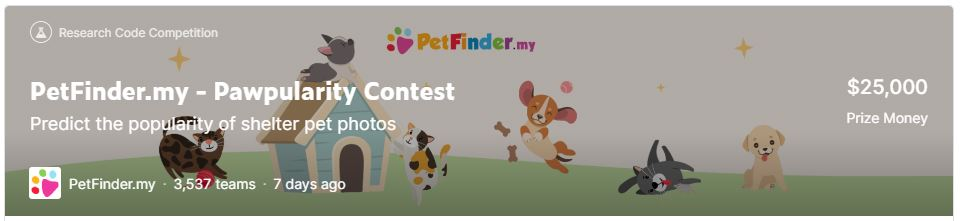

In [12]:
Image("files/petfinder_logo.JPG")

# ВВЕДЕНИЕ

Оценка привлекательности по фотографии – одно из интересных направлений в области компьютерного зрения. Например, нейросеть Photofeeler D3 [1] умеет определять три качества человека по его фотографии: привлекательность, уровень интеллекта и безопасность. Данную модель используют сайты знакомств для рекомендаций улучшений фотографий для своих клиентов. Например, человек может запустить программу с данной нейронной сетью, а она в режиме реального времени выполняет оценку того, как человек выглядит в кадре с точки зрения привлекательности для противоположного пола. И таким образом человек сможет подобрать позу, одежду и аксессуары для получения максимального результата на сайте знакомств. Такие нейронные сети выглядят полезными и очень выгодными с точки зрения коммерции.

Так же данное направление может использоваться не только для коммерческих целей. Например, для помощи найти бездомному животному хорошего хозяина. Миллионы бездомных животных страдают на улицах или подвергаются эвтаназии в приютах каждый день по всему миру. Можно ожидать, что домашние животные с привлекательными фотографиями вызовут больший интерес и найдут своих будущих хозяев быстрее. 

PetFinder.my - это ведущая платформа защиты животных Малайзии, в которой представлено более 180 000 животных. Компания предложила соревнование «Pawpularity Contest» на платформе Kaggle [2] с целью получения модели предсказания привлекательности домашних животных по фотографии. Целью данной работы является создание модели для данного соревнования.

# Список полезных источников

[1] Photofeeler-D3: A Neural Network with Voter Modeling for Dating Photo Impression Prediction (https://arxiv.org/abs/1904.07435)

[2] PetFinder.my – Pawpularity Contest (https://www.kaggle.com/c/petfinder-pawpularity-score/overview)

[3] Ноутбук с анализом данных для PetFinder Pawpularity Contest (https://github.com/inject0r1945/ds_projects/blob/main/kaggle/PetFinder.me_Pawpularity_Contest/petfinder_EDA.ipynb)

[4] Ноутбук с демонстрацией генерации новых признаков и удаления дубликатов (https://github.com/inject0r1945/ds_projects/blob/main/kaggle/PetFinder.me_Pawpularity_Contest/petfinder_data_mining.ipynb)

[5] Разработанная библиотека для построения модели (https://github.com/inject0r1945/ds_projects/blob/main/kaggle/PetFinder.me_Pawpularity_Contest/pet_finder_library.py)

[6] Пример оптимизации модели с Optuna (https://github.com/inject0r1945/ds_projects/blob/main/kaggle/PetFinder.me_Pawpularity_Contest/petfinder_hyperopt.ipynb)

[7] Файлы весов для обученных в ноутбуке моделей (https://disk.yandex.ru/d/IZotUcQa_1aw6Q)

# 1	Постановка задачи

На соревновании [2] представлен датасет из 9912 фотографий с домашними животными. Для каждой фотографии существует оценка привлекательности (pawpularity) от 0 до 100.
Оценка привлекательности рассчитывалась на основе статистики просмотра страниц каждого профиля питомца на страницах списка с использованием алгоритма, который нормализует данные трафика с разных платформ (веб, мобильные). Повторяющиеся просмотры, посещения поисковых роботов и спонсируемые профили исключаются для анализа.
Требуется реализовать модель, которая сможет предсказать оценку привлекательности фотографии из данной методики расчета.

Итоговое качество модели на соревновании оценивается с помощью RMSE.


# 2 Описание модели

На слайде приведена схема результирующей ансамблевой модели. Ансамбль состоит из блока основной модели и дополнительной. Дополнительная модель является опциональной и была введена для улучшения результатов основной модели.

Вначале данные разбиваются на пять фолдов, для каждого фолда обучается отдельная модель экстрактора признаков и полносвязной сети. Архитектура экстрактора признаков и полносвязной сети являются гиперпараметрами, которые можно изменять на лету. Если дополнительная модель не подключена, то с  выхода полносвязной сети с каждого фолда получаем предсказания и усредняем.

Если подключена дополнительная модель, то на ее вход поступает выходы каждого фолда из экстрактора признаков, которые конкатенируются с дополнительными признаками. В результате будут усредняться предсказания двух моделей с помощью установленных весов.

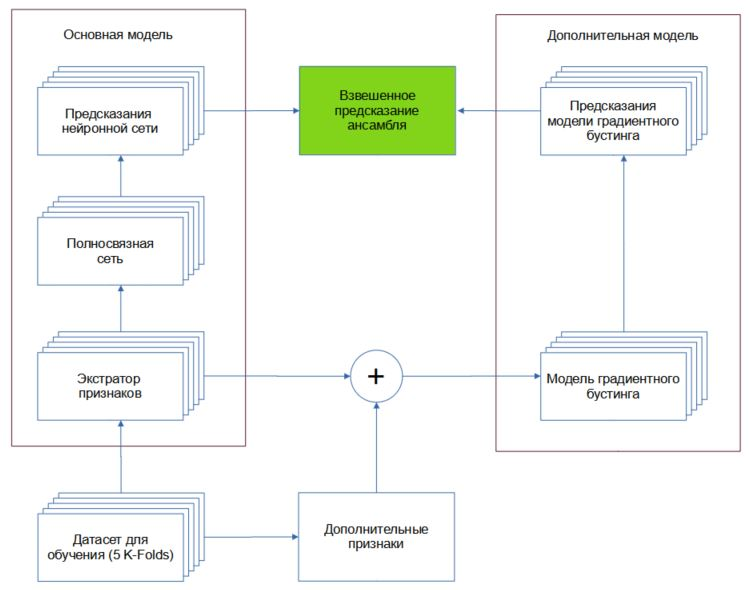

In [3]:
Image("files/network_schema.JPG")

В качестве экстратора признаков выбрана классификационная модель PetFinderTransferModelBCE без использования дополнительных признаков. Дополнительные признаки будет передавать только в блок моделей градиентного бустинга. Для экстраторка признаков используем SWIN Transformer (swin_base_patch4_window7_224_in22k). В качестве модели градиентного бустинга будем использовать CatBoost.

Предобученные веса для всех моделей можно загрузить по ссылке [7]. Данные веса были получены с помощью этого ноутбука.

Далее будет рассмотрены реализованные классы из библиотеки pet_finder_library для построения модели.

Для построения модели в библиотеке [5] разработаны следующие классы:

- TransferNet (генерация модели для экстрактора признаков и полносвязной сети);
- PetDataMining (предобработка данных для обучения, генерация новых признаков с использованием детектора YoloV5, подробно в [4]);
- PetDataSet (хранилище данных для входа модели);
- PetDataLoader (загрузчик данных, использующий PetDataSet);
- PetFinderTransferModel (регрессионная модель, использующая функцию ошибки RMSE);
- PetFinderTransferModelWithAddFeatures(регрессионная модель, использующая функцию ошибки RMSE и все дополнительные признаки);
- PetFinderTransferModelBCE (модель классификации, использующая функцию ошибки Binary Cross Entropy);
- PetFinderTransferModelBCEWithAddFeatures(модель классификации, использующая функцию ошибки Binary Cross Entropy и все дополнительные признаки).

Код с комментариями можно посмотреть в [5].



# 3 Демонстрация модели

Для демонстрации будет реализована полная схема модели с блоком моделей градиентного бустинга.

В качестве экстратора признаков возьмем классификационную модель PetFinderTransferModelBCE без использования дополнительных признаков. 

Дополнительные признаки будет передавать только в блок моделей градиентного бустинга. Для экстратора признаков используем SWIN Transformer (swin_base_patch4_window7_224_in22k).

В качестве модели градиентного бустинга будем использовать CatBoost.

## 3.1 Конфигурация модели

Предполагается, что у нас уже есть предобработанные данные с помощью детекции в файле files/mining_train.csv . Предобработать данные можно с помощью ноутбука [4].

Обработка данных и формирования файла для обучения описаны в другом ноутбуке, посвященному майнингу данных с помощью детекции. Описание параметров можно найти в описании классов в разработанной библиотеке [5].

Данные гиперпараметры были подобраны с помощью Optuna на модели PetFinderTransferModelBCEWithAddFeatures. Пример оптимизации модели можно найти в ноутбуке [6].

In [7]:
SEED = 42

config = {'seed': SEED,
          'get_optim_params': False,
          'orig_train_csv': f'{INPUT_DATA_PREFIX}/train.csv',
          'orig_test_csv': f'{INPUT_DATA_PREFIX}/test.csv',
          'model': {
              'model_name': 'swin_base_patch4_window7_224_in22k', 
              'output_dims': [1022, 1], 
              'use_weights': False, 
              'plot_epoch_loss': True,
              'dropout': 0.3232967040113801, 
              'learning_rate': 4.812096281914617e-06, 
              'l2_regularization': 0.2766337962203344,
              'adam_betas': (0.37438095497909607, 0.7504122450294624),
              'pretrained': True,
              'seed': SEED,
              'full_trainable': True,
              'use_mixup': True,
              'mixup_alpha': 0.5, 
              'mixup_prob': 0.5,
          },
          'dataloader': {
              'seed': SEED,
              'n_splits': 5,
              'size_dataset': None,
              'use_kldiv': False,
              'train_photo_dir': f'{INPUT_DATA_PREFIX}/train/',
              'test_photo_dir': f'{INPUT_DATA_PREFIX}/test/',
              'train_csv': "files/mining_train.csv",
              'test_csv': "mining_test.csv",
              'dataset_params': {
                    'gaussian_sigma': 2,
                    'pca_for_add_features': False,
                    'std_for_add_features': True,
                    'p_vflip': 0.5,
                    'p_hflip': 0.5,
                    'val_augmentation': False,
                    'train_augmentation': True,
                    'image_size': 224,
                    'class_weights': None,
                    'seed': SEED,
               },
              'train_loader_params': {
                    'batch_size': 32,
                    'shuffle': True,
                    'num_workers': 2,
                    'pin_memory': False,
                    'drop_last': True,
              },
              'val_loader_params': {
                    'batch_size': 32,
                    'shuffle': False,
                    'num_workers': 2,
                    'pin_memory': False,
                    'drop_last': False
              },
              'test_loader_params': {
                    'batch_size': 1,
                    'shuffle': False,
                    'num_workers': 2,
                    'pin_memory': False,
                    'drop_last': False
              }
          },
         'trainer': {
              'max_epochs': 20,
              'gpus': 1 if torch.cuda.is_available() else 0,
              'progress_bar_refresh_rate': 10,
              'resume_from_checkpoint': None,
          },
}

Модель требует указания ссылки в том числе и на датасет для теста. Поэтому предобработаем его и сохраним в файл.

In [8]:
data_miner = PetDataMining(petfinder_csv=config['orig_test_csv'], drop_duplicates=False, plot_duplicate=False,
                 duplicate_thresh=0.9, plot_detector=False,
                 image_filepath=config['dataloader']['test_photo_dir'])
test_mining_df = data_miner.start()
test_mining_df.to_csv(config['dataloader']['test_csv'], index=False)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-1-21 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 574 layers, 140730220 parameters, 0 gradients
Adding AutoShape... 
100%|██████████| 8/8 [00:01<00:00,  7.85it/s]


## 3.2 Обучение экстрактора признаков и полносвязной сети

Разбиваем данные на 5 фолдов с помощью параметра n_splits в конфигурации загрузчика. Для каждого фолда обучаем отдельную модель нейронной сети и сохраняем веса на диск.

Включаем раннюю остановку обучения по значению RMSE на валидационной части. Если в течении 3 эпох RMSE не изменится на 0.01, то обучение модели будет остановленно, будут загружены веса с наилучшим значением RMSE на валидации.

In [9]:
%matplotlib inline

kfold_pet_dataloaders = PetDataLoader.create_kfold_loaders(**config['dataloader'])
kfold_models = []
kfold_best_models = []

for fold_number in range(len(kfold_pet_dataloaders)):

    torch.cuda.empty_cache()

    pet_dataloader = kfold_pet_dataloaders[fold_number]

    model = PetFinderTransferModelBCE(**config['model'])
    checkpoint = ModelCheckpoint(dirpath='checkpoint/', monitor='rmse_val_loss', mode='min')
    callbacks = [
            EarlyStopping('rmse_val_loss', min_delta=0.01, patience=3, mode='min'), 
            checkpoint
        ]

    trainer = pl.Trainer(**config['trainer'], callbacks=callbacks)
    trainer.fit(model, pet_dataloader)

    best_model = PetFinderTransferModelBCE.load_from_checkpoint(checkpoint.best_model_path)
    torch.save(best_model.state_dict(), f'{OUTPUT_DATA_PREFIX}/petfinder_transfermodel_std_swin_bce_mixup_{fold_number}.pth')
    
    best_model.eval()
    kfold_best_models.append(best_model)
    
    model.eval()
    kfold_models.append(model)

Loading pretrained weights from url (https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224_22k.pth)


Модель с FOLD #0


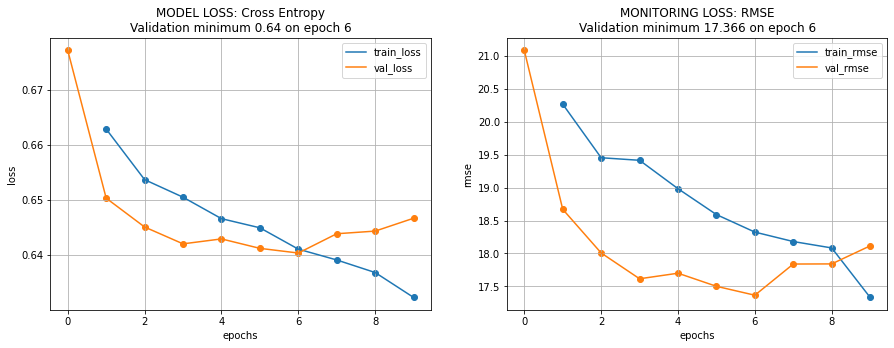

Модель с FOLD #1


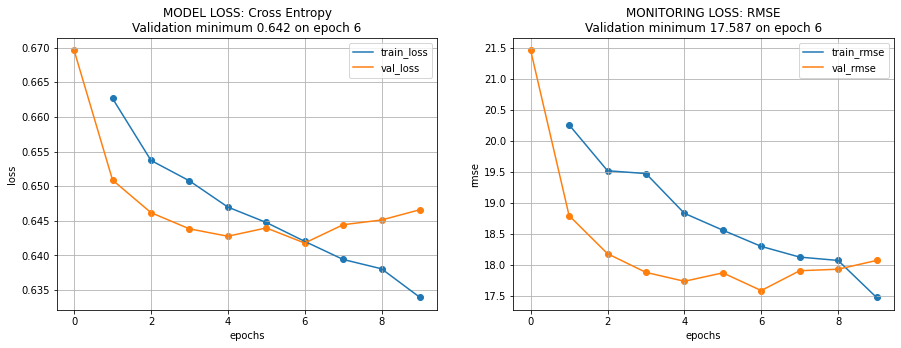

Модель с FOLD #2


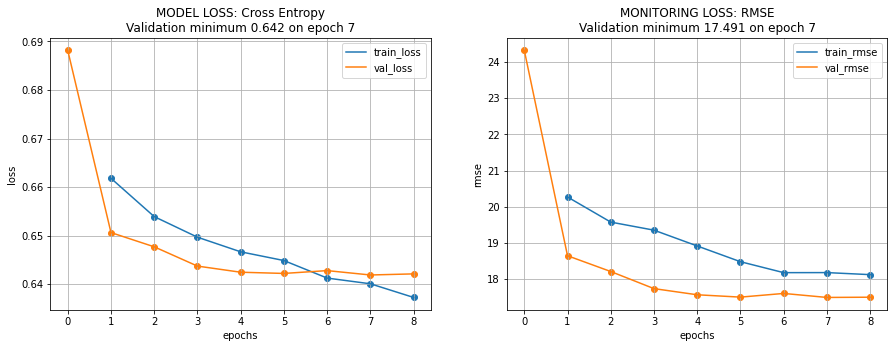

Модель с FOLD #3


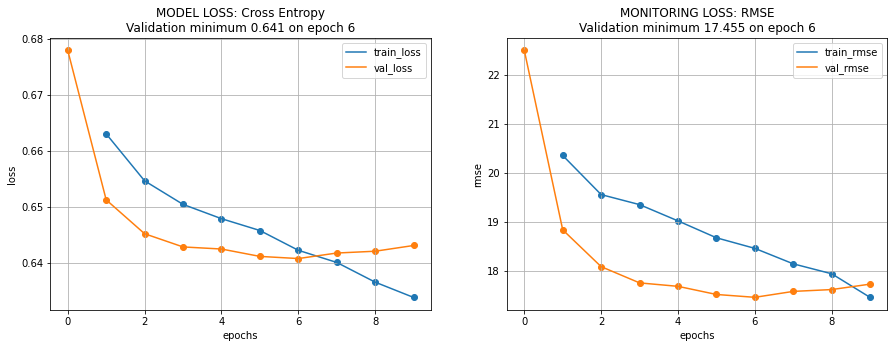

Модель с FOLD #4


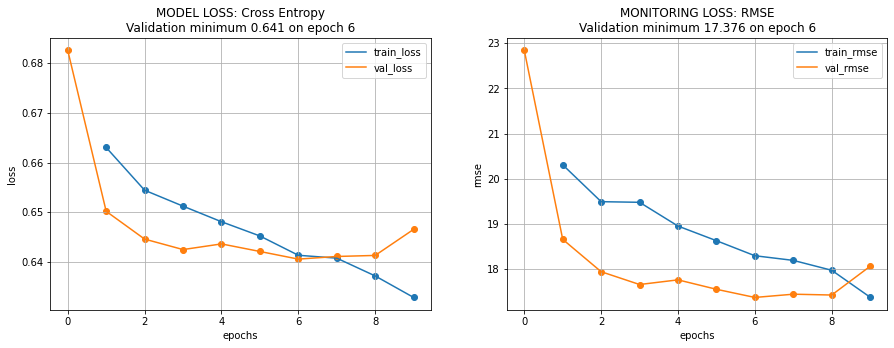

In [10]:
for idx, model in enumerate(kfold_models):
    print(f'Модель с FOLD #{idx}')
    model.plot_history_loss(clear_output=False)

## 3.3 Обучение блока моделей CatBoost

Загружаем предобученные модели нейронной сети (экстрактор признаков + полносвязная сеть)

In [14]:
pet_kfold_dataloaders = PetDataLoader.create_kfold_loaders(**config['dataloader'])
# настраиваем обратный порядок фолдов датасета. Цель - модель SVR и NN должны обучаться на разных данных.
pet_kfold_dataloaders = pet_kfold_dataloaders[::-1]

# Если True, то загружаем веса с диска, сохраненные при обучении модели.
# Иначе используем модели из kfold_best_models
nn_load_from_disk = False

if nn_load_from_disk:
    kfold_nn_models = []
    models_num = 5
    for index in range(models_num):
        model = PetFinderTransferModelBCE(**config['model'])
        model.load_state_dict(torch.load(f'{OUTPUT_DATA_PREFIX}/petfinder_transfermodel_std_swin_bce_mixup_{index}.pth'))
        model.eval()
        model.to('cuda' if torch.cuda.is_available() else 'cpu')
        kfold_nn_models.append(model)
else:
    kfold_nn_models = kfold_best_models

Loading pretrained weights from url (https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224_22k.pth)
Loading pretrained weights from url (https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224_22k.pth)
Loading pretrained weights from url (https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224_22k.pth)
Loading pretrained weights from url (https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224_22k.pth)
Loading pretrained weights from url (https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224_22k.pth)


Параметры CatBoost

In [144]:
cb_params = {'loss_function' : 'RMSE',
                     'eval_metric' : 'RMSE',
                     'iterations' : 20000,
                     'od_type': 'Iter', 
                     'od_wait': 200,
                     'learning_rate' : 0.002,
                     'task_type' : 'GPU' if torch.cuda.is_available() else 'CPU',
                     'devices' : '0',
                     'verbose' : 0,
                     'random_seed': 42}

### 3.3.1 Получение данных для обучения модели CatBoost

Для обучения CatBoost требуется сформировать матрицу NxM. Где N - число изображений в обучающем датасете. А M - размер признаков из нейронной сети.

А так же необходимо сформировать вектор целевых значений обучающего датасета размером N.

In [132]:
# Тренировочные данные для входа CatBoost каждого фолда
fold_train_embeddings = []
# Валидационные целевые значения для входа CatBoost каждого фолда
fold_train_targets = []

for fold_number, nn_model in enumerate(kfold_nn_models):
    
    # Получаем загрузчик данных для fold_number
    pet_dataloader = pet_kfold_dataloaders[fold_number]
    
    # Количество батчей в загрузчике на обучении
    train_batch_count = len(pet_dataloader.train_dataloader())
    # Размер одного батча на обучении
    train_batch_size = config['dataloader']['train_loader_params']['batch_size']
    # Количество изображений в фолде на обучении
    train_data_length = train_batch_count * train_batch_size
    
    # Тензор с данными для обучения CatBoost
    train_embeddings = None
    # Тензор с целевыми метками для обучения CatBoost
    train_targets = torch.zeros(size=[1,train_data_length], dtype=torch.float32)

    for idx, data_batch in enumerate(pet_dataloader.train_dataloader()):
        data_batch['x_data'] = data_batch['x_data'].cuda()
        
        # Получаем фичи из экстрактора признаков для батча
        with torch.no_grad():
            _, batch_features = nn_model(data_batch, sigmoid=False, return_features=True)
            
        batch_features = batch_features.detach().cpu()

        if train_embeddings is None:
            # Создаем тензор обущающих данных из экстрактора признаков.
            # Количество строк равно train_data_length.
            # А количество колонов равно размеру выхода экстратора признаков + кол-во доп. признаков
            backbone_features_count = batch_features.shape[1]
            add_features_count = data_batch['additional_features'].shape[1]
            train_embeddings = torch.zeros(size=[train_data_length, backbone_features_count+add_features_count], dtype=torch.float32)

        # Соединияем данные из экстрактора признаков с дополнительными фичами
        result_embeddings = torch.hstack([batch_features, data_batch['additional_features']])
        
        # Формируем матрицу обучающих данных из экстрактора признаков
        train_embeddings[train_batch_size*idx:train_batch_size*idx+train_batch_size] = result_embeddings
        # Формируем вектор целевых значений оценки привлекательности для обучения
        train_targets[:, train_batch_size*idx:train_batch_size*idx+train_batch_size] = data_batch['pawpularity']
        
        del(batch_features)
        del(data_batch)
        gc.collect()
        torch.cuda.empty_cache()

    train_embeddings = train_embeddings.numpy()
    train_targets = train_targets.numpy().flatten()  

    fold_train_embeddings.append(train_embeddings)
    fold_train_targets.append(train_targets)

### 3.3.2 Формирование данных для валидации модели CatBoost

Для валидации CatBoost требуется сформировать аналогичную матрицу NxM и вектор целевых значений размером N из датасета валидации.

Так же в данном цикле будем сохранять предсказания нейронной сети на валидации, потребуются для итогового усреднения результата.

In [133]:
# Валидационные данные для входа CatBoost каждого фолда
fold_val_embeddings = []
# Валидационные целевые значения  для входа CatBoost каждого фолда
fold_val_targets = []
# Предсказания нейронной сети для усреднения оценок с CatBoost для каждого фолда
fold_val_nn_predictions = []

for fold_number, nn_model in enumerate(kfold_nn_models):

    # Получаем загрузчик данных для fold_number
    pet_dataloader = pet_kfold_dataloaders[fold_number]

    # Количество батчей в загрузчике на валидации
    val_batch_count = len(pet_dataloader.val_dataloader())
    # Размер одного батча на валидации
    val_batch_size = config['dataloader']['val_loader_params']['batch_size']
    # Количество изображений в фолде на валидации
    val_data_length = val_batch_count * val_batch_size
    
    # Тензор с данными для валидации CatBoost
    val_embeddings = None
    # Вектор с целевыми метками для валидации CatBoost
    val_targets = torch.zeros(size=[1,val_data_length], dtype=torch.float32)
    # Вектор с предсказаниями нейронной сети на валидации
    val_nn_predictions = torch.zeros(size=[1,val_data_length], dtype=torch.float32)
    
    for idx, data_batch in enumerate(pet_dataloader.val_dataloader()):
        data_batch['x_data'] = data_batch['x_data'].cuda()
        
        # Получаем фичи из экстрактора признаков для батча
        with torch.no_grad():
            nn_logits, batch_features = nn_model(data_batch, sigmoid=True, return_features=True)
            
        nn_logits = nn_logits.detach().cpu()
        batch_features = batch_features.detach().cpu()

        if val_embeddings is None:
            # Создаем матрицу валидационных данных из экстрактора признаков.
            # Количество строк равно val_data_length.
            # А количество колонов равно размеру выхода экстратора признаков + кол-во доп. признаков
            backbone_features_count = batch_features.shape[1]
            add_features_count = data_batch['additional_features'].shape[1]
            val_embeddings = torch.zeros(size=[val_data_length, backbone_features_count+add_features_count], dtype=torch.float32)

        # Соединияем данные из экстрактора признаков с дополнительными фичами
        result_embeddings = torch.hstack([batch_features, data_batch['additional_features']])
        
        # Последний батч может отличаться по размеру, поэтолму последний батч будем обрабатывать отдельно
        # и учитывать его размер
        if idx != (val_batch_count - 1):
            val_embeddings[val_batch_size*idx:val_batch_size*idx+val_batch_size] = result_embeddings
            val_targets[:, val_batch_size*idx:val_batch_size*idx+val_batch_size] = data_batch['pawpularity']
            val_nn_predictions[:, val_batch_size*idx:val_batch_size*idx+val_batch_size] = nn_logits * 100
        else:
            val_embeddings[val_batch_size*idx:val_batch_size*idx+len(result_embeddings)] = result_embeddings
            val_targets[:, val_batch_size*idx:val_batch_size*idx+len(result_embeddings)] = data_batch['pawpularity']
            val_nn_predictions[:, val_batch_size*idx:val_batch_size*idx+len(result_embeddings)] = nn_logits * 100
            
            val_embeddings = val_embeddings[:val_batch_size*idx+len(result_embeddings)]
            val_targets = val_targets[:, :val_batch_size*idx+len(result_embeddings)]
            val_nn_predictions = val_nn_predictions[:, :val_batch_size*idx+len(result_embeddings)]
        
        del(batch_features)
        del(data_batch)
        gc.collect()
        torch.cuda.empty_cache()   

    val_embeddings = val_embeddings.numpy()
    val_targets = val_targets.numpy().flatten()
    val_nn_predictions = val_nn_predictions.numpy().flatten()

    fold_val_embeddings.append(val_embeddings)
    fold_val_targets.append(val_targets)
    fold_val_nn_predictions.append(val_nn_predictions)

### 3.3.3 Обучение моделей CatBoost

In [134]:
# Вес для предсказаний модели CatBoost
w_catboost = 0.5
# Вес для предсказаний нейронной сети
w_nn = 1 - w_catboost

assert (w_catboost + w_nn) == 1

In [145]:
# Здесь хранятся предсказания CatBoost для каждого фолда
fold_val_cat_predictions = []
# Здесь хранятся обученные модели CatBoost для каждого фолда
kfold_cat_models = []

for fold_number in range(len(kfold_nn_models)):

    train_embeddings = fold_train_embeddings[fold_number]
    train_targets = fold_train_targets[fold_number]
    val_embeddings = fold_val_embeddings[fold_number]
    val_targets = fold_val_targets[fold_number]
    val_nn_predictions = fold_val_nn_predictions[fold_number]
        
    cat_model = CatBoostRegressor(**cb_params)
    cat_model.fit(train_embeddings, train_targets, eval_set=(val_embeddings, val_targets), 
                  use_best_model=True, verbose = 50)
    print(f"CatBoost Model tree Count: {cat_model.tree_count_}")
    cat_model.save_model(OUTPUT_DATA_PREFIX + f'/catboost_swin_bce_mixup_{fold_number}.cbm', format='cbm')
    kfold_cat_models.append(cat_model)
    
    val_cat_predictions = cat_model.predict(val_embeddings)
    
    nn_rmse = mean_squared_error(val_targets, val_nn_predictions, squared=False)
    cat_rmse = mean_squared_error(val_targets, val_cat_predictions, squared=False)
    ensemble_rmse = mean_squared_error(val_targets, w_nn * val_nn_predictions + w_catboost * val_cat_predictions, squared=False)
    
    fold_val_cat_predictions.append(val_cat_predictions)
    
    print("")
    print(f"ФОЛД №{fold_number}")
    print(f"RMSE NN {nn_rmse}")
    print(f"RMSE CATBOOST {cat_rmse}")
    print(f"ENSEMBLE {ensemble_rmse}")
    print("=======================================================================")

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 20.5929136	test: 20.6149098	best: 20.6149098 (0)	total: 53.1ms	remaining: 17m 41s
50:	learn: 20.1122517	test: 20.1223711	best: 20.1223711 (50)	total: 2.52s	remaining: 16m 24s
100:	learn: 19.6986217	test: 19.6944611	best: 19.6944611 (100)	total: 4.99s	remaining: 16m 22s
150:	learn: 19.3285545	test: 19.3161023	best: 19.3161023 (150)	total: 7.44s	remaining: 16m 18s
200:	learn: 19.0057448	test: 18.9814023	best: 18.9814023 (200)	total: 9.87s	remaining: 16m 12s
250:	learn: 18.7133577	test: 18.6827196	best: 18.6827196 (250)	total: 12.3s	remaining: 16m 9s
300:	learn: 18.4517721	test: 18.4176713	best: 18.4176713 (300)	total: 14.8s	remaining: 16m 6s
350:	learn: 18.2232034	test: 18.1827844	best: 18.1827844 (350)	total: 17.2s	remaining: 16m 3s
400:	learn: 18.0174920	test: 17.9754575	best: 17.9754575 (400)	total: 19.6s	remaining: 15m 59s
450:	learn: 17.8311253	test: 17.7854287	best: 17.7854287 (450)	total: 22s	remaining: 15m 55s
500:	learn: 17.6630111	test: 17.6167771	best: 17.6167771 (50

### 3.3.4 Итоговые метрики обучения ансамбля

In [146]:
total_val_targets = np.hstack(fold_val_targets).flatten()
total_nn_predictions = np.hstack(fold_val_nn_predictions).flatten()
total_cat_predictions = np.hstack(fold_val_cat_predictions).flatten()

total_nn_rmse = mean_squared_error(total_val_targets, total_nn_predictions, squared=False)
total_cat_rmse = mean_squared_error(total_val_targets, total_cat_predictions, squared=False)
total_ensemble_rmse = mean_squared_error(total_val_targets, total_nn_predictions*w_nn + total_cat_predictions*w_catboost, squared=False)

print(f"FINAL RMSE NN {total_nn_rmse}")
print(f"FINAL RMSE CATBOOST {total_cat_rmse}")
print(f"FINAL ENSEMBLE {total_ensemble_rmse}")

FINAL RMSE NN 16.172523498535156
FINAL RMSE CATBOOST 16.288161473154556
FINAL ENSEMBLE 16.13607982624158


### 3.3.5 Загрузка весов предобученных моделей CatBoost (по необходимости)

In [147]:
catboost_load_from_disk = True

if catboost_load_from_disk:
    kfold_cat_models = []
    models_num = 5
    for index in range(models_num):
        cat_model = CatBoostRegressor(**cb_params)
        kfold_cat_models.append(cat_model.load_model(f"{OUTPUT_DATA_PREFIX}/catboost_swin_bce_mixup_{index}.cbm"))

# 4 Демонстрация работы модели на валидационном датасете

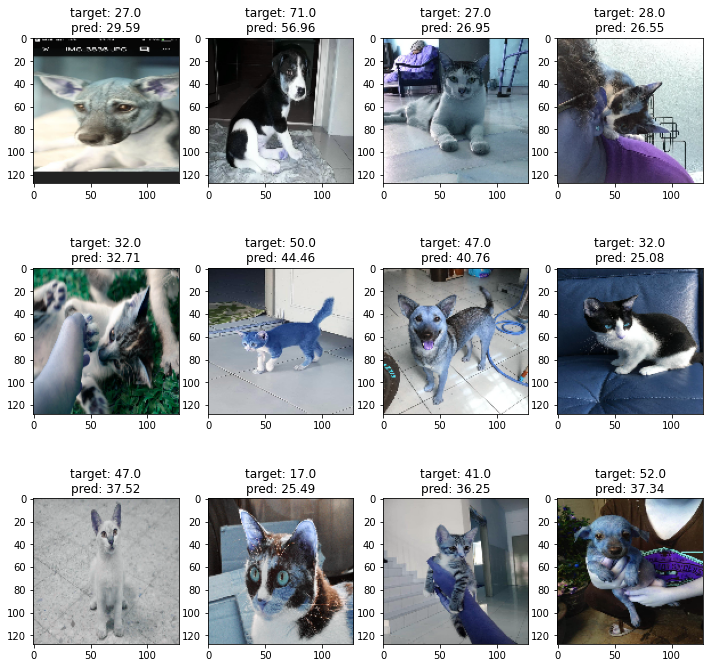

In [148]:
pet_dataloader.val_loader_params['batch_size'] = 1
fig, axes = plt.subplots(3, 4, figsize=(12, 12))
axes = axes.flatten()
models_num = 5

for index, val_data in enumerate(pet_dataloader.val_dataloader()):
    if index == len(axes):
        break
    target_pawpularity = val_data['pawpularity'][0]
    kfold_predictions = []
    val_data['x_data'] = val_data['x_data'].to('cuda')
    val_data['additional_features'] = val_data['additional_features'].to('cuda')

    for fold_number in range(models_num):
        nn_model = kfold_nn_models[fold_number]
        cat_model = kfold_cat_models[fold_number]
        logit, nn_features = nn_model(val_data, sigmoid=True, return_features=True)
        logit = logit.cpu().detach().item()
        catboost_features = np.hstack([nn_features.cpu().detach().numpy(), val_data['additional_features'].to('cpu').numpy()])
        
        nn_pred = logit * 100
        catboost_pred = cat_model.predict(catboost_features)[0]
        
        kfold_predictions.append(nn_pred*w_nn + catboost_pred*w_catboost)

    pred_pawpularity = round(sum(kfold_predictions) / len(kfold_predictions), 2)

    img_source = cv2.imread(val_data['image_path'][0], cv2.IMREAD_COLOR)
    img_source = cv2.resize(img_source, dsize=(128,128))
    axes[index].imshow(img_source)
    axes[index].set_title(f"target: {target_pawpularity}\npred: {pred_pawpularity}")

plt.show()

#5 Формирование файла для сабмита в Kaggle

In [150]:
models_num = 5

with open('submission.csv', 'w', encoding='utf-8') as file:
    
    header = 'Id,Pawpularity\n'
    file.write(header)
    
    for image_data in pet_dataloader.predict_dataloader():
        
        image_data['x_data'] = image_data['x_data'].to('cuda')
        image_data['additional_features'] = image_data['additional_features'].to('cuda')
        
        kfold_predictions = []
        
        for fold_number in range(models_num):
            
            nn_model = kfold_nn_models[fold_number]
            regression_model = kfold_cat_models[fold_number]
            logit, features = nn_model(image_data, sigmoid=True, return_features=True)
            logit = logit.cpu().detach().item()

            catboost_features = np.hstack([nn_features.cpu().detach().numpy(), image_data['additional_features'].to('cpu').numpy()])

            nn_pred = logit * 100
            catboost_pred = regression_model.predict(catboost_features)[0]

            kfold_predictions.append(nn_pred*w_nn +catboost_pred*w_catboost)
        
        predict = sum(kfold_predictions) / len(kfold_predictions)
        
        file_hash = image_data['hash'][0]
        text = f'{file_hash},{predict}\n'
        file.write(text)

# 6 Результат модели на Kaggle

Без использования блока CatBoost:

Private Score: 17.55870  
Public Score: 18.24565

С использованием блока CatBoost:

Private Score: 17.46633  
Public Score: 18.25116


В результате работы получено 1650 место из 3537 в Private Score

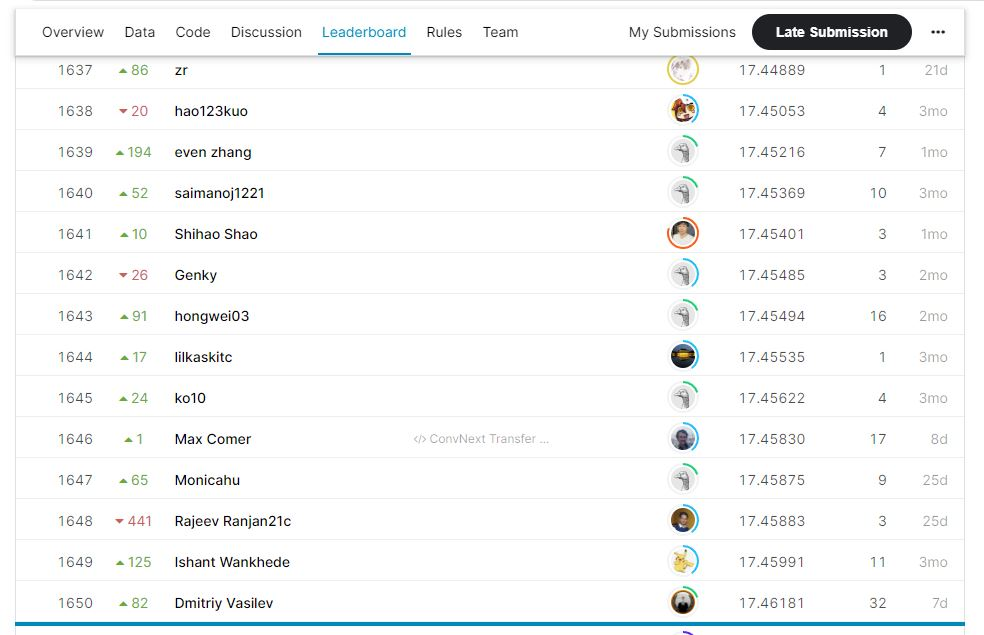

In [13]:
Image("files/private_leaderboard.JPG")